## Ansatzes

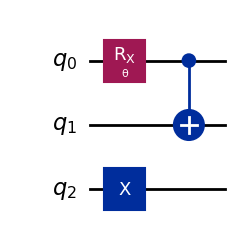

In [1]:
from qiskit.circuit import QuantumCircuit, Parameter

theta = Parameter("θ")

qc = QuantumCircuit(3)
qc.rx(theta, 0)
qc.cx(0, 1)
qc.x(2)

qc.draw("mpl")

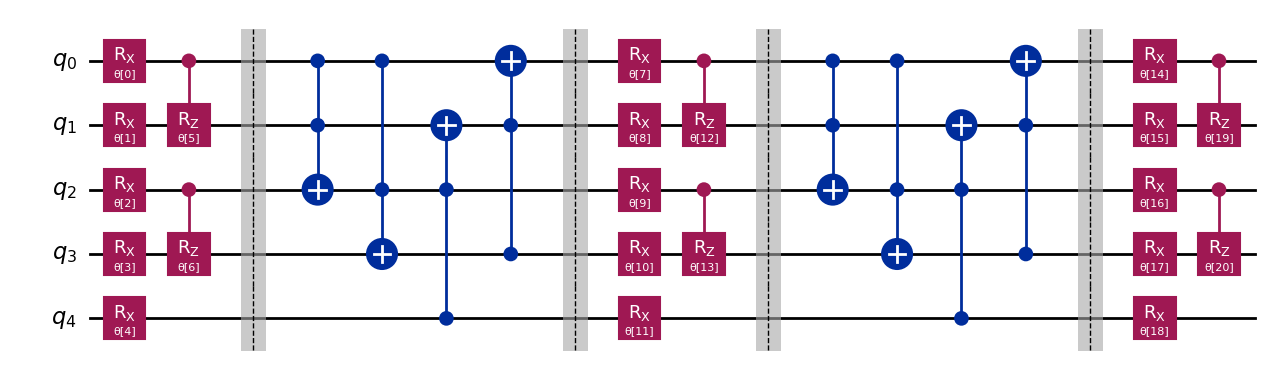

In [2]:
from qiskit.circuit.library import NLocal, CCXGate, CRZGate, RXGate
from qiskit.circuit import Parameter

theta = Parameter("θ")
ansatz = NLocal(
    num_qubits=5,
    rotation_blocks=[RXGate(theta), CRZGate(theta)],
    entanglement_blocks=CCXGate(),
    entanglement=[[0, 1, 2], [0, 2, 3], [4, 2, 1], [3, 1, 0]],
    reps=2,
    insert_barriers=True,
)
ansatz.decompose().draw("mpl")

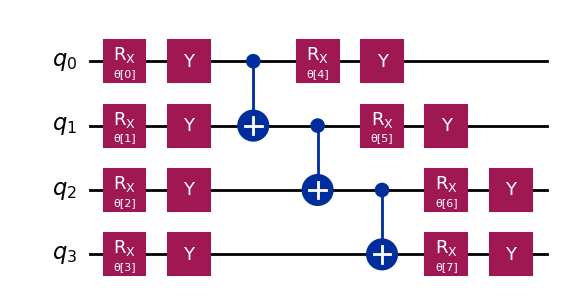

In [3]:
from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(4, su2_gates=["rx", "y"], entanglement="linear", reps=1)
ansatz.decompose().draw("mpl")

## Cost Functions

In [4]:
def cost_func_vqe(params, circuit, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = (circuit, hamiltonian, params)
    cost = estimator.run([pub]).result()[0].data.evs

#    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return cost

## Optimizers

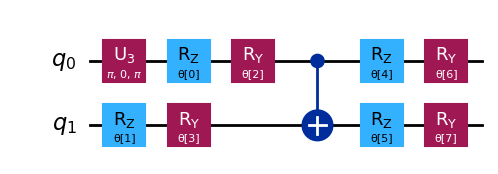

In [5]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import TwoLocal
import numpy as np

theta_list = (2 * np.pi * np.random.rand(1, 8)).tolist()
observable = SparsePauliOp.from_list([("XX", 1), ("YY", -3)])

reference_circuit = QuantumCircuit(2)
reference_circuit.x(0)

variational_form = TwoLocal(
    2,
    rotation_blocks=["rz", "ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=1,
)
ansatz = reference_circuit.compose(variational_form)

ansatz.decompose().draw('mpl')

In [6]:
from qiskit.primitives import StatevectorEstimator
estimator = StatevectorEstimator()

# SciPy minimizer routine
from scipy.optimize import minimize
import numpy as np
x0 = np.ones(8)

result = minimize(cost_func_vqe, x0, args=(ansatz, observable, estimator), method="SLSQP")

result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -3.9999999964410433
       x: [ 1.000e+00  1.000e+00 -1.571e+00 -4.573e-05 -1.207e+00
           -1.935e+00  4.079e-01 -4.079e-01]
     nit: 12
     jac: [ 0.000e+00 -2.980e-08 -7.959e-04  2.546e-04  1.381e-03
            1.381e-03  5.430e-04  5.431e-04]
    nfev: 112
    njev: 12

## VQE Putting Everything Together

In [7]:
from qiskit.quantum_info import SparsePauliOp

observable_1 = SparsePauliOp.from_list([("II", 2), ("XX", -2), ("YY", 3), ("ZZ", -3)])

In [8]:
def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, hamiltonian, params)
    cost = estimator.run([pub]).result()[0].data.evs

    return cost

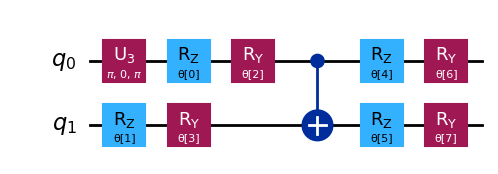

In [9]:
from qiskit.circuit.library import TwoLocal
from qiskit import QuantumCircuit

import numpy as np

reference_circuit = QuantumCircuit(2)
reference_circuit.x(0)

variational_form = TwoLocal(
    2,
    rotation_blocks=["rz", "ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=1,
)
raw_ansatz = reference_circuit.compose(variational_form)

raw_ansatz.decompose().draw('mpl')

In [10]:
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit.primitives import StatevectorSampler as Sampler
estimator = Estimator()
sampler = Sampler()

In [11]:
import numpy as np

x0 = np.ones(raw_ansatz.num_parameters) 
print(x0)

[1. 1. 1. 1. 1. 1. 1. 1.]


In [12]:
# SciPy minimizer routine
from scipy.optimize import minimize
import time

start_time = time.time()

result = minimize(cost_func_vqe, x0, args=(raw_ansatz, observable_1, estimator), method="COBYLA", options={'maxiter': 1000, 'disp': True})

end_time = time.time()
execution_time = end_time - start_time


   Normal return from subroutine COBYLA

   NFVALS =  126   F =-6.000000E+00    MAXCV = 0.000000E+00
   X = 1.171843E-01   2.581581E+00   1.570781E+00   7.225530E-06   2.381742E+00
       7.599394E-01   3.258624E-01   3.258437E-01


In [13]:
result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -5.999999978267783
       x: [ 1.172e-01  2.582e+00  1.571e+00  7.226e-06  2.382e+00
            7.599e-01  3.259e-01  3.258e-01]
    nfev: 126
   maxcv: 0.0

In [14]:
from numpy.linalg import eigvalsh

solution_eigenvalue = min(eigvalsh(observable_1.to_matrix()))

print(f"""Number of iterations: {result.nfev}""")
print(f"""Time (s): {execution_time}""")

print(
    f"Percent error: {abs((result.fun - solution_eigenvalue)/solution_eigenvalue):.2e}"
)

Number of iterations: 126
Time (s): 0.2768888473510742
Percent error: 3.62e-09
